In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
!pip install wordcloud
from wordcloud import WordCloud
import tkinter as tk
from tkinter import messagebox
!pip install contractions
import contractions 
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
data = pd.read_csv(r"trum_tweet_sentiment_analysis.csv", encoding="ISO-8859-1")
data.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [5]:
def preprocess_text(text):
    # Handle non-string input (e.g., NaN or float)
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Expand contractions using the contractions library
    text = contractions.fix(text)
    # Remove URLs
    text = re.sub(r'https?\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove emojis (Unicode ranges for emojis)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_text'] = data['text'].apply(preprocess_text)

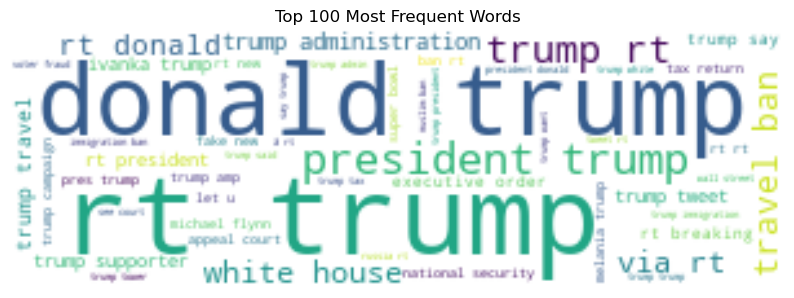

In [6]:
# --- Visualization: Word Cloud (Top 100 Words) ---
all_words = " ".join(data["cleaned_text"])
# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
width=300,
height=100,
background_color="white",
max_words=100 # Limit to top 100 words
).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 Most Frequent Words")
plt.show()

In [7]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(
data["cleaned_text"], # Features (text)
data["Sentiment"], # Labels
test_size=0.2,
random_state=42
)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # Vocabulary based ONLY on training data
# Use the same tokenizer to transform both sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [9]:
# Calculate max_len using percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95)) # Adjust percentile as needed
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

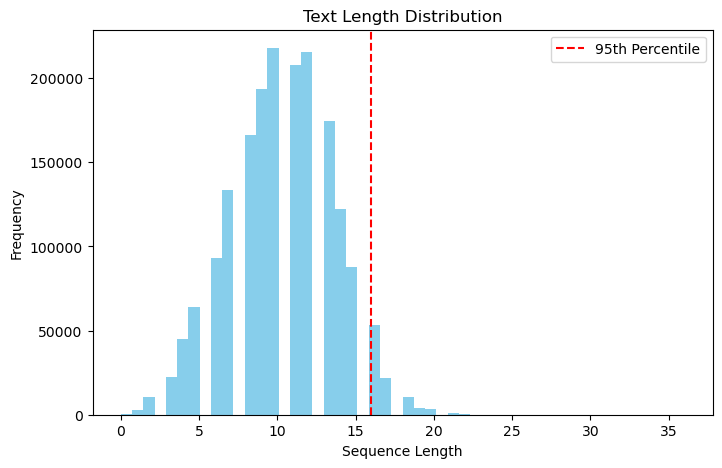

In [10]:
X_seq = tokenizer.texts_to_sequences(data["cleaned_text"])
seq_lengths = [len(seq) for seq in X_seq]
plt.figure(figsize=(8, 5))
plt.hist(seq_lengths, bins=50, color="skyblue")
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel("Frequency")
plt.axvline(np.percentile(seq_lengths, 95), color="red", linestyle="dashed", label="95th Percentile"
)
plt.legend()
plt.show()

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
# Example parameters
vocab_size = 10000 # Size of vocabulary
embedding_dim = 128 # Dimension of embedding vectors
max_length = max_len # Maximum length of input sequences
rnn_units = 64 # Number of RNN units

rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(units=rnn_units, return_sequences=False),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=rnn_units),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint ('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

In [45]:
rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [46]:
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    
    batch_size=64,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9109 - loss: 0.2228
Epoch 1: val_accuracy improved from -inf to 0.95283, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 242s 13ms/step - accuracy: 0.9109 - loss: 0.2228 - val_accuracy: 0.9528 - val_loss: 0.1358
Epoch 2/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9598 - loss: 0.1162
Epoch 2: val_accuracy improved from 0.95283 to 0.95613, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 233s 13ms/step - accuracy: 0.9598 - loss: 0.1162 - val_accuracy: 0.9561 - val_loss: 0.1284
Epoch 3/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9672 - loss: 0.0965
Epoch 3: val_accuracy improved from 0.95613 to 0.95876, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 235s 13ms/step - accuracy: 0.9672 - loss: 0.0965 - val_accuracy: 0.9588 - val_loss: 0.1206
Epoch 4/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9714 - loss: 0.0851
Epoch 4: val_accuracy improved from 0.95876 to 0.96145, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 251s 14ms/step - accuracy: 0.9714 - loss: 0.0851 - val_accuracy: 0.9614 - val_loss: 0.1182
Epoch 5/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9733 - loss: 0.0795
Epoch 5: val_accuracy did not improve from 0.96145
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 351s 19ms/step - accuracy: 0.9733 - loss: 0.0795 - val_accuracy: 0.9607 - val_loss: 0.1170
Epoch 6/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9746 - loss: 0.0757
Epoch 6: val_accuracy did not improve from 0.96145
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 383s 21ms/step - accuracy: 0.9746 - loss: 0.0757 - val_accuracy: 0.9560 - val_loss: 0.1284
Epoch 7/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9757 - loss: 0.0732
Epoch 7: val_accuracy did not improve from 0.96145
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 382s 21ms/step - accuracy: 0.9757 - loss: 0.0732 - val_accuracy: 0.9607 - val_loss: 0.1265
Epoch 8/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9759 - 

In [47]:
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9154 - loss: 0.2108
Epoch 1: val_accuracy did not improve from 0.96145
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 405s 22ms/step - accuracy: 0.9154 - loss: 0.2107 - val_accuracy: 0.9568 - val_loss: 0.1216
Epoch 2/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9630 - loss: 0.1053
Epoch 2: val_accuracy improved from 0.96145 to 0.96373, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 346s 19ms/step - accuracy: 0.9630 - loss: 0.1053 - val_accuracy: 0.9637 - val_loss: 0.1048
Epoch 3/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9722 - loss: 0.0810
Epoch 3: val_accuracy improved from 0.96373 to 0.96754, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 332s 18ms/step - accuracy: 0.9722 - loss: 0.0810 - val_accuracy: 0.9675 - val_loss: 0.0978
Epoch 4/10
18500/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9775 - loss: 0.0667
Epoch 4: val_accuracy improved from 0.96754 to 0.96852, saving model to best_model.h5


18502/18502 ━━━━━━━━━━━━━━━━━━━━ 330s 18ms/step - accuracy: 0.9775 - loss: 0.0667 - val_accuracy: 0.9685 - val_loss: 0.0953
Epoch 5/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9819 - loss: 0.0544
Epoch 5: val_accuracy did not improve from 0.96852
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 327s 18ms/step - accuracy: 0.9819 - loss: 0.0544 - val_accuracy: 0.9681 - val_loss: 0.0980
Epoch 6/10
18499/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9851 - loss: 0.0450
Epoch 6: val_accuracy did not improve from 0.96852
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 329s 18ms/step - accuracy: 0.9851 - loss: 0.0450 - val_accuracy: 0.9682 - val_loss: 0.1041
Epoch 7/10
18501/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9872 - loss: 0.0389
Epoch 7: val_accuracy did not improve from 0.96852
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 15651s 846ms/step - accuracy: 0.9872 - loss: 0.0389 - val_accuracy: 0.9675 - val_loss: 0.1123
Epoch 7: early stopping
Restoring model weights from the end of the best e

In [48]:
# Evaluation
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

# Evaluate both models
evaluate_model(rnn_model, X_test_pad, y_test, "Simple RNN")
evaluate_model(lstm_model, X_test_pad, y_test, "LSTM")

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step

Simple RNN Evaluation:
Accuracy: 0.9603
Confusion Matrix:
[[242613   5950]
 [  8741 112721]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.98      0.97    248563
    Positive       0.95      0.93      0.94    121462

    accuracy                           0.96    370025
   macro avg       0.96      0.95      0.95    370025
weighted avg       0.96      0.96      0.96    370025

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step

LSTM Evaluation:
Accuracy: 0.9686
Confusion Matrix:
[[242703   5860]
 [  5759 115703]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98    248563
    Positive       0.95      0.95      0.95    121462

    accuracy                           0.97    370025
   macro avg       0.96      0.96      0.96    370025
weighted avg       0.97      0.97      0.97    370025



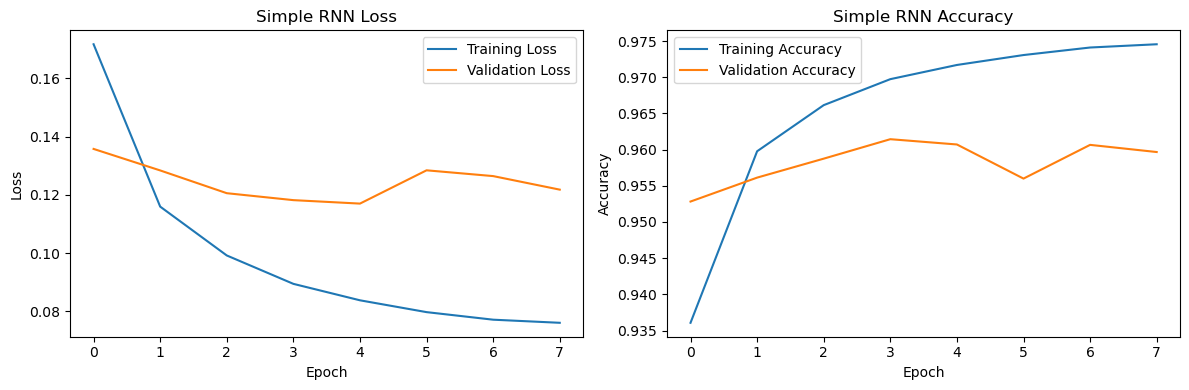

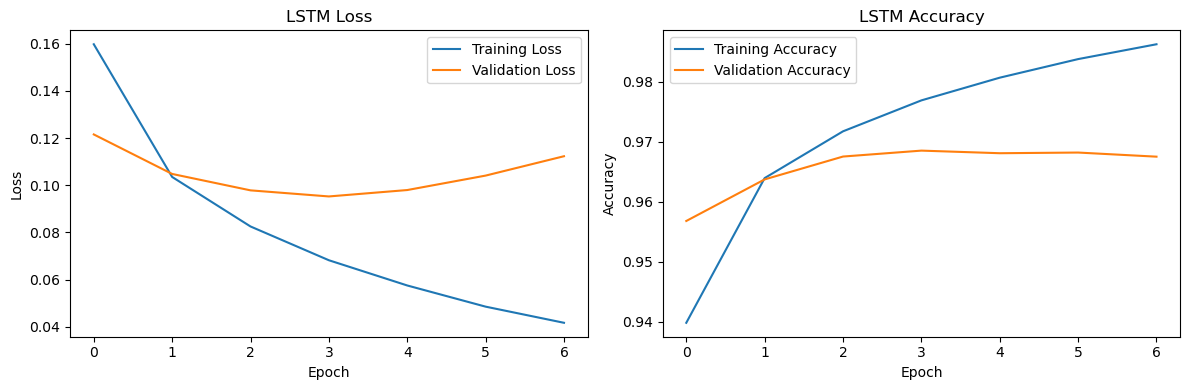

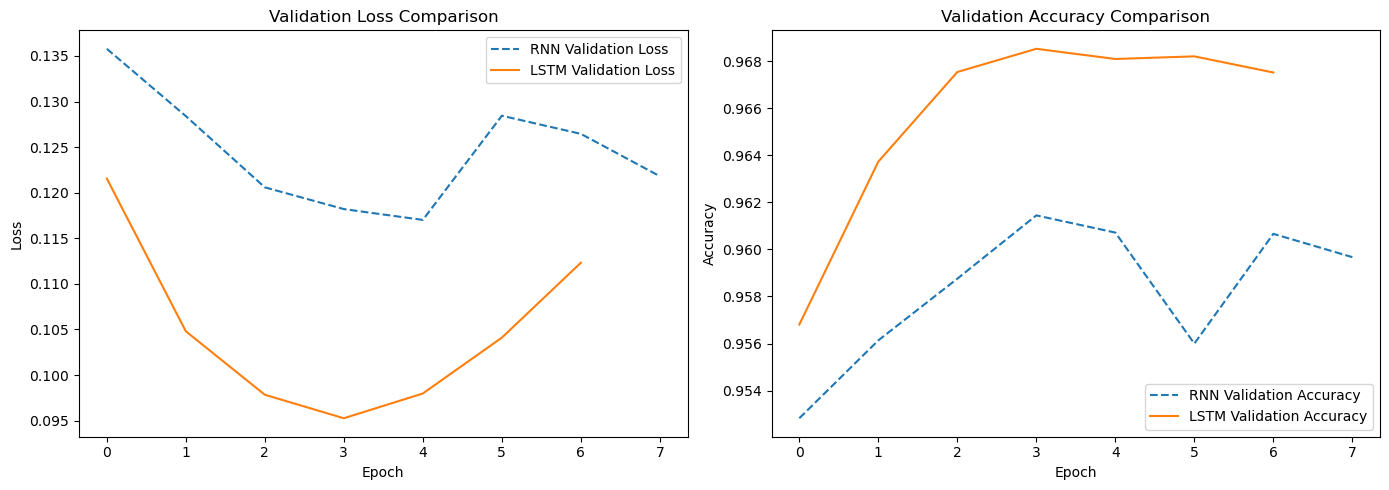

In [49]:
# Visualization function
def plot_metrics(rnn_history, lstm_history):
    # Individual plots for each model
    for history, model_name in [(rnn_history, "Simple RNN"), (lstm_history, "LSTM")]:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Loss
        ax1.plot(history.history['loss'], label='Training Loss')
        ax1.plot(history.history['val_loss'], label='Validation Loss')
        ax1.set_title(f'{model_name} Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Accuracy
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title(f'{model_name} Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    # Combined comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss comparison
    ax1.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', linestyle='--')
    ax1.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
    ax1.set_title('Validation Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy comparison
    ax2.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy', linestyle='--')
    ax2.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
    ax2.set_title('Validation Accuracy Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot metrics
plot_metrics(rnn_history, lstm_history)

In [50]:
def predict_sentiment(user_input):
    print("Input:", user_input)
    # Step 1: Preprocess the input text
    cleaned_input = preprocess_text(user_input)
    print("Cleaned Input:", cleaned_input)
    
    # Step 2: Tokenize the cleaned text
    sequence = tokenizer.texts_to_sequences([cleaned_input])
    print("Sequence:", sequence)
    
    # Step 3: Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    print("Padded Sequence Shape:", padded_sequence.shape)
    
    # Step 4: Predict using the trained model
    print("Starting prediction...")
    prediction_prob = lstm_model.predict(padded_sequence, verbose=1)
    print("Prediction Probability:", prediction_prob)
    prediction = "Positive" if prediction_prob[0] > 0.5 else "Negative"
    print("Predicted Sentiment:", prediction)
    
    return prediction

In [51]:
test_input = "I love this product!"
result = predict_sentiment(test_input)
print(result)

Input: I love this product!
Cleaned Input: love product
Sequence: [[143, 501]]
Padded Sequence Shape: (1, 16)
Starting prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction Probability: [[0.9416376]]
Predicted Sentiment: Positive
Positive


In [ ]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming these are defined from previous steps:
# - preprocess_text: Function to clean text (from Task 1)
# - tokenizer: Keras Tokenizer fitted on training data (from Task 2)
# - lstm_model: Trained LSTM model (from Task 3)
# - max_len: Maximum sequence length from padding (from Task 2)

# Function to predict sentiment for a single tweet
def predict_sentiment(text):
    # Preprocess the input text
    cleaned_text = preprocess_text(text)
    # Tokenize and pad the text
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    # Predict sentiment using the LSTM model
    pred = lstm_model.predict(padded, verbose=0)[0][0]
    # Return sentiment label
    return 'Positive' if pred > 0.5 else 'Negative'

# Function to handle GUI prediction
def predict_sentiment_gui():
    user_input = entry.get()  # Get the text input from the user
    if user_input.strip() == "":
        messagebox.showwarning("Input Error", "Please enter a tweet for prediction!")
        return
    # Predict sentiment using the trained model
    prediction = predict_sentiment(user_input)
    # Display the result in the label
    result_label.config(text=f"Predicted Sentiment: {prediction}")

# Create the main window
root = tk.Tk()
root.title("Twitter Sentiment Predictor")

# Label for instructions
instruction_label = tk.Label(root, text="Enter a tweet to predict its sentiment:", font=("Arial", 14))
instruction_label.pack(pady=10)

# Entry box for user to input a tweet
entry = tk.Entry(root, width=50, font=("Arial", 12))
entry.pack(pady=10)

# Predict button to trigger sentiment prediction
predict_button = tk.Button(root, text="Predict Sentiment", font=("Arial", 12), command=predict_sentiment_gui)
predict_button.pack(pady=10)

# Label to display the predicted sentiment
result_label = tk.Label(root, text="", font=("Arial", 14), fg="blue")
result_label.pack(pady=10)

# Run the Tkinter main loop
root.mainloop()